<a href="https://colab.research.google.com/github/CorentinMAG/CV/blob/main/ML4CV_5_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start with our usual imports and figure adjustments.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from timeit import default_timer as timer
from functools import partial
import copy

plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.rcParams['font.size'] = 16

Then we load CIFAR10, and we create the usual `Dataset`s and `DataLoader`s.

This time, though, we do **NOT** flatten the images (notice we do not add the `LambdaTransform` that was reshaping them to the list of transforms that are applied to the data). Instead, we use another `Transfomation` to normalize them, by subtracting the mean and dividing by the standard deviation of each channel. Here we simply assume they are both 0.5, you can modify this code to estimate them on CIFAR-10 and use the estimated values.

In [ ]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])]) 
train_ds = torchvision.datasets.CIFAR10(root="/data/", train=True, transform=tsfms, download=True)
test_ds = torchvision.datasets.CIFAR10(root="/data/", train=False, transform=tsfms)

classes = train_ds.classes
n_classes = len(classes)
input_side = train_ds[0][0].shape[-1]

Files already downloaded and verified


In [ ]:
splitted_datasets = torch.utils.data.random_split(train_ds, [45000, 5000])
actual_train_subds = splitted_datasets[0]
valid_subds = splitted_datasets[1]

In [ ]:
small_actual_train_subds = torch.utils.data.Subset(actual_train_subds, range(500))
small_valid_subds = torch.utils.data.Subset(valid_subds, range(100))
small_test_subds = torch.utils.data.Subset(test_ds, range(100))

Note there is a difference with respect to our usual DataLoader creation: we double the batch size for the validation and test sets. Since they will be run with `torch.no_grad()` and will not compute gradients, they require less memory, and therefore we can use larger batch sizes when evaluating models.

In [ ]:
batch_size = 128
small_actual_train_dl = torch.utils.data.DataLoader(small_actual_train_subds, batch_size=batch_size, shuffle=True)
small_valid_dl = torch.utils.data.DataLoader(small_valid_subds, batch_size=2*batch_size)
small_test_dl = torch.utils.data.DataLoader(small_test_subds, batch_size=2*batch_size)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
actual_train_dl = torch.utils.data.DataLoader(actual_train_subds, batch_size=batch_size)
valid_dl = torch.utils.data.DataLoader(valid_subds, batch_size=2*batch_size)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=2*batch_size)

Since we start to have several layers with a respectable number of parameters, it is time to move our training on the GPU. 

You should change runtime type, by selecting GPU in the menu `Runtime`->`Change runtime type`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# This should print a CUDA device:

print(device)

cuda:0


Now we define our first CNN. Similarly to the FC case, we create a variable architecture to experiment with a number of choices.

In [ ]:
def Conv2dReLUPool(in_channels, out_channels, kernel_size, stride, batch_norm=True, pooling=True):
  layers = [
    torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=(kernel_size-1)//2)
  ]

  if batch_norm:
    layers.append(torch.nn.BatchNorm2d(out_channels))

  layers.append(torch.nn.ReLU(inplace=True))

  if pooling:
    layers.append(torch.nn.MaxPool2d(2,2))

  return torch.nn.Sequential(*layers)

def LinearReLU(in_features, out_features, batch_norm=True):
  layers = [
    torch.nn.Linear(in_features, out_features)
  ]

  if batch_norm:
    layers.append(torch.nn.BatchNorm1d(out_features));

  layers.append(torch.nn.ReLU(inplace=True))

  return torch.nn.Sequential(*layers)


class VanillaCNN(torch.nn.Module):
  def __init__(self, input_side, hidden_width, n_classes, n_additional_convs=0, use_batch_norm=True):
    super(VanillaCNN, self).__init__()
    self.first_conv = Conv2dReLUPool(3, 16, 5, 1, use_batch_norm, pooling=False)
    self.additional_convs =  torch.nn.ModuleList(
        [Conv2dReLUPool(2 ** (i+4), 2 ** (i+5), 3, 1, use_batch_norm, pooling=i<3) for i in range(n_additional_convs)])
    n_features = 2**(n_additional_convs+4) * ((input_side//(2**(min(n_additional_convs,3))))**2)
    self.first_fc = LinearReLU(n_features, hidden_width, use_batch_norm) 
    self.second_fc = LinearReLU(hidden_width, hidden_width, use_batch_norm) 
    self.third_fc = torch.nn.Linear(hidden_width, n_classes)

  def forward(self, x):
    x = self.first_conv(x)
    for layer in self.additional_convs:
      x = layer(x)
    x = torch.flatten(x, start_dim=1)
    x = self.first_fc(x)
    x = self.second_fc(x)
    x = self.third_fc(x)
    return x



One way to get an overview of the number and kind of layers in a `torch.nn.Module` is by using the `torchsummary` package

In [ ]:
cnn = VanillaCNN(input_side, 128, n_classes, 4, True)
import torchsummary
torchsummary.summary(cnn, (3,32,32), batch_size=128, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 32, 32]           1,216
       BatchNorm2d-2          [128, 16, 32, 32]              32
              ReLU-3          [128, 16, 32, 32]               0
            Conv2d-4          [128, 32, 32, 32]           4,640
       BatchNorm2d-5          [128, 32, 32, 32]              64
              ReLU-6          [128, 32, 32, 32]               0
         MaxPool2d-7          [128, 32, 16, 16]               0
            Conv2d-8          [128, 64, 16, 16]          18,496
       BatchNorm2d-9          [128, 64, 16, 16]             128
             ReLU-10          [128, 64, 16, 16]               0
        MaxPool2d-11            [128, 64, 8, 8]               0
           Conv2d-12           [128, 128, 8, 8]          73,856
      BatchNorm2d-13           [128, 128, 8, 8]             256
             ReLU-14           [128, 12

Let's check what another instantiation looks like and how many parameters it has by cycling over the list of trainable parameters of our model. Is this what you expected based on the code above? Do the dimensions match in a way that you expected?

In [ ]:
cnn = VanillaCNN(input_side=input_side, hidden_width=128, n_classes=n_classes, n_additional_convs=4, use_batch_norm=False)
params = 0
for p in cnn.parameters():
  print(type(p), p.shape)
  params += np.prod(p.shape)
print(f"Total number of parameters: {params}, ({params*4/1024/1024:.1f} MB)")

<class 'torch.nn.parameter.Parameter'> torch.Size([16, 3, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 16, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([256, 128, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([256])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 4096])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 128])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])
Total number of parameters: 93

In [ ]:
cnn.state_dict().keys()

odict_keys(['first_conv.0.weight', 'first_conv.0.bias', 'additional_convs.0.0.weight', 'additional_convs.0.0.bias', 'additional_convs.1.0.weight', 'additional_convs.1.0.bias', 'additional_convs.2.0.weight', 'additional_convs.2.0.bias', 'additional_convs.3.0.weight', 'additional_convs.3.0.bias', 'first_fc.0.weight', 'first_fc.0.bias', 'second_fc.0.weight', 'second_fc.0.bias', 'third_fc.weight', 'third_fc.bias'])

In [ ]:
cnn.state_dict()['first_conv.0.weight'].shape

torch.Size([16, 3, 5, 5])

Let's plot the kernels of the first convolutional layer. We should see random patterns, as we haven't trained them yet. 

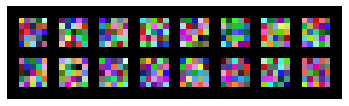

In [ ]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')

def show_first_kernels(state_dict):
  show(torchvision.utils.make_grid(state_dict['first_conv.0.weight'].cpu(), normalize=True, scale_each=True))
show_first_kernels(cnn.state_dict())

Let's check that a randomly initialized model has expected loss value and accuracy. 

This also shows how to move weights and data onto the GPU by using the `to` function of `Module`s and `Tensor`s.

In [ ]:
def ncorrect(scores, y):
  y_hat = torch.argmax(scores, 1)
  return (y_hat==y).sum()

def accuracy(scores, y):
  correct = ncorrect(scores, y)
  return correct.true_divide(y.shape[0])
  
def test_model(device, cnn, dl):
  with torch.no_grad():
    total_loss = 0
    n_samples = 0
    n_correct = 0
    for data in dl:
      images = data[0].to(device) # move images to GPU
      labels = data[1].to(device) # move labels to GPU
      scores = cnn.forward(images)
      loss = F.cross_entropy(scores, labels)
      total_loss += loss.item() * data[0].shape[0]
      n_samples += data[0].shape[0]
      n_correct += ncorrect(scores, labels).item()
    return total_loss/n_samples, n_samples, n_correct

start=timer()
loss, n_samples, n_correct = test_model(device, cnn.to(device), test_dl) # move model to GPU
print(f"Loss {loss}, Accuracy {n_correct/n_samples}")
end = timer()
print(f"Elapsed time (s): {end-start}")

Loss 2.3036390731811522, Accuracy 0.1
Elapsed time (s): 1.9849860799999988


Then we define our usual function to train a model. 

Note the use of `nn.train()` and `nn.eval()` to tell the model in which phase we are: we have to start to include these calls since we are using BatchNorm, which behaves differently between training and test time.

In [ ]:
def train_loop(device, input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm,
               train_dl, epochs, partial_opt, 
               valid_dl=None, verbose=False, print_every=5):
  best_valid_acc = 0
  best_params = []
  best_epoch = -1

  nn = VanillaCNN(input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm)
  nn.to(device)

  # We "complete" the partial function by calling it and specifying the missing parameters
  opt = partial_opt(nn.parameters())

  for e in range(epochs):
    #if epochs-e == 10:
    #  for param_group in opt.param_groups:
    #    param_group['lr'] /= 10
    #train
    train_loss = 0
    train_samples = 0
    train_acc = 0
    nn.train() # put the model in training mode
    for train_data in train_dl:
      train_images = train_data[0].to(device)
      train_labels = train_data[1].to(device)
      scores = nn.forward(train_images)
      loss = F.cross_entropy(scores, train_labels)
      train_loss += loss.item() * train_data[0].shape[0]
      train_samples += train_data[0].shape[0]
      train_acc += ncorrect(scores, train_labels).item()
      loss.backward()
      opt.step()
      opt.zero_grad()

    train_acc /= train_samples
    train_loss /= train_samples
    
    # validation
    nn.eval() # put the model in evaluation mode
    with torch.no_grad():
      valid_loss = 0
      valid_samples = 0
      valid_acc = 0
      if valid_dl is not None:
        for valid_data in valid_dl:
          valid_images = valid_data[0].to(device)
          valid_labels = valid_data[1].to(device)
          valid_scores = nn.forward(valid_images)
          valid_loss += F.cross_entropy(valid_scores, valid_labels).item() * valid_data[0].shape[0]
          valid_samples += valid_data[0].shape[0]
          valid_acc += ncorrect(valid_scores, valid_labels).item()
        valid_acc /= valid_samples
        valid_loss /= valid_samples
      
      if valid_dl is None or valid_acc > best_valid_acc:
        best_valid_acc = valid_acc if valid_dl is not None else 0
        best_params = copy.deepcopy(nn.state_dict())
        best_epoch = e
        
      
    if verbose and e % print_every == 0:
      print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if valid_dl is None else f" - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}"))
  
  if verbose and valid_dl is not None:
    print(f"Best epoch {best_epoch}, best acc {best_valid_acc}")

  return best_valid_acc, best_params, best_epoch

Let's compare a not too deep architecture with and without BN. 

Let's also make sure we can perfectly fit a small training set (i.e. reach train accuracy 1).

In [ ]:
start = timer()
lr=1e-3
hidden_width=128
n_additional_convs=3
use_batch_norm=False
p_opt = partial(torch.optim.Adam, lr=lr)

_, best_params, best_epoch = train_loop(device, input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm,
           train_dl=small_actual_train_dl, epochs=80, partial_opt=p_opt, 
           valid_dl=small_valid_dl, verbose=True)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 2.294 - train acc 0.136 - valid loss 2.359 - valid acc 0.060
Epoch 5: train loss 1.993 - train acc 0.302 - valid loss 2.102 - valid acc 0.220
Epoch 10: train loss 1.724 - train acc 0.382 - valid loss 2.069 - valid acc 0.200
Epoch 15: train loss 1.501 - train acc 0.464 - valid loss 2.048 - valid acc 0.200
Epoch 20: train loss 1.183 - train acc 0.566 - valid loss 1.895 - valid acc 0.280
Epoch 25: train loss 0.836 - train acc 0.736 - valid loss 2.155 - valid acc 0.260
Epoch 30: train loss 0.568 - train acc 0.806 - valid loss 2.450 - valid acc 0.300
Epoch 35: train loss 0.200 - train acc 0.946 - valid loss 3.379 - valid acc 0.320
Epoch 40: train loss 0.065 - train acc 0.988 - valid loss 4.203 - valid acc 0.290
Epoch 45: train loss 0.020 - train acc 1.000 - valid loss 5.219 - valid acc 0.300
Epoch 50: train loss 0.004 - train acc 1.000 - valid loss 5.867 - valid acc 0.280
Epoch 55: train loss 0.002 - train acc 1.000 - valid loss 6.123 - valid acc 0.280
Epoch 60: train lo

In [ ]:
start = timer()
lr=1e-3
hidden_width=128
n_additional_convs=3
use_batch_norm=True
p_opt = partial(torch.optim.Adam, lr=lr)

_, best_params, best_epoch = train_loop(device, input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm,
           train_dl=small_actual_train_dl, epochs=25, partial_opt=p_opt, 
           valid_dl=small_valid_dl, verbose=True)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 2.156 - train acc 0.210 - valid loss 2.311 - valid acc 0.100
Epoch 5: train loss 0.559 - train acc 0.986 - valid loss 2.514 - valid acc 0.100
Epoch 10: train loss 0.107 - train acc 1.000 - valid loss 1.997 - valid acc 0.270
Epoch 15: train loss 0.039 - train acc 1.000 - valid loss 1.928 - valid acc 0.390
Epoch 20: train loss 0.021 - train acc 1.000 - valid loss 1.984 - valid acc 0.360
Best epoch 15, best acc 0.39
Elapsed time (s): 3.704436717999897


Let's see if the difference holds when we train on the full dataset.

In [ ]:
start = timer()
lr=1e-3
hidden_width=128
n_additional_convs=3
use_batch_norm=False
p_opt = partial(torch.optim.Adam, lr=lr)

_, best_params, best_epoch = train_loop(device, input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm,
           train_dl=actual_train_dl, epochs=20, partial_opt=p_opt, 
           valid_dl=valid_dl, verbose=True, print_every=1)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 1.670 - train acc 0.384 - valid loss 1.390 - valid acc 0.497
Epoch 1: train loss 1.268 - train acc 0.541 - valid loss 1.158 - valid acc 0.595
Epoch 2: train loss 1.043 - train acc 0.627 - valid loss 0.993 - valid acc 0.655
Epoch 3: train loss 0.893 - train acc 0.686 - valid loss 0.923 - valid acc 0.684
Epoch 4: train loss 0.778 - train acc 0.730 - valid loss 0.918 - valid acc 0.690
Epoch 5: train loss 0.685 - train acc 0.763 - valid loss 0.894 - valid acc 0.704
Epoch 6: train loss 0.605 - train acc 0.789 - valid loss 0.849 - valid acc 0.720
Epoch 7: train loss 0.548 - train acc 0.810 - valid loss 0.901 - valid acc 0.710
Epoch 8: train loss 0.489 - train acc 0.829 - valid loss 0.942 - valid acc 0.712
Epoch 9: train loss 0.446 - train acc 0.844 - valid loss 0.985 - valid acc 0.717
Epoch 10: train loss 0.394 - train acc 0.864 - valid loss 1.113 - valid acc 0.699
Epoch 11: train loss 0.355 - train acc 0.872 - valid loss 1.124 - valid acc 0.702
Epoch 12: train loss 0.327

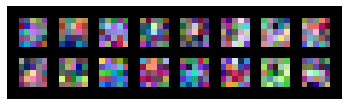

In [ ]:
show_first_kernels(best_params)

In [ ]:
start = timer()
lr=1e-3
hidden_width=128
n_additional_convs=3
use_batch_norm=True
p_opt = partial(torch.optim.Adam, lr=lr)

_, best_params, best_epoch = train_loop(device, input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm,
           train_dl=actual_train_dl, epochs=20, partial_opt=p_opt, 
           valid_dl=valid_dl, verbose=True, print_every=1)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 1.152 - train acc 0.593 - valid loss 0.941 - valid acc 0.675
Epoch 1: train loss 0.754 - train acc 0.734 - valid loss 0.831 - valid acc 0.716
Epoch 2: train loss 0.579 - train acc 0.799 - valid loss 0.826 - valid acc 0.725
Epoch 3: train loss 0.451 - train acc 0.845 - valid loss 0.854 - valid acc 0.728
Epoch 4: train loss 0.347 - train acc 0.881 - valid loss 1.049 - valid acc 0.696
Epoch 5: train loss 0.275 - train acc 0.906 - valid loss 1.011 - valid acc 0.716
Epoch 6: train loss 0.208 - train acc 0.927 - valid loss 1.065 - valid acc 0.719
Epoch 7: train loss 0.160 - train acc 0.945 - valid loss 1.111 - valid acc 0.728
Epoch 8: train loss 0.126 - train acc 0.957 - valid loss 1.103 - valid acc 0.742
Epoch 9: train loss 0.103 - train acc 0.964 - valid loss 1.245 - valid acc 0.733
Epoch 10: train loss 0.089 - train acc 0.969 - valid loss 1.389 - valid acc 0.724
Epoch 11: train loss 0.075 - train acc 0.974 - valid loss 1.462 - valid acc 0.717
Epoch 12: train loss 0.061

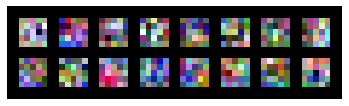

In [ ]:
show_first_kernels(best_params)

Let's train the batch-norm model on the full training set.

In [ ]:
start = timer()
lr=1e-3
hidden_width=128
n_additional_convs=3
use_batch_norm=True
p_opt = partial(torch.optim.Adam, lr=lr)

_, best_params, _ = train_loop(device, input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm,
           train_dl=train_dl, epochs=best_epoch, partial_opt=p_opt, 
           valid_dl=None, verbose=True, print_every=1)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 1.131 - train acc 0.600
Epoch 1: train loss 0.739 - train acc 0.740
Epoch 2: train loss 0.572 - train acc 0.800
Epoch 3: train loss 0.440 - train acc 0.849
Epoch 4: train loss 0.344 - train acc 0.882
Epoch 5: train loss 0.263 - train acc 0.910
Epoch 6: train loss 0.210 - train acc 0.928
Epoch 7: train loss 0.164 - train acc 0.944
Epoch 8: train loss 0.130 - train acc 0.955
Epoch 9: train loss 0.105 - train acc 0.964
Epoch 10: train loss 0.080 - train acc 0.973
Epoch 11: train loss 0.072 - train acc 0.975
Epoch 12: train loss 0.074 - train acc 0.974
Epoch 13: train loss 0.068 - train acc 0.976
Epoch 14: train loss 0.058 - train acc 0.980
Epoch 15: train loss 0.051 - train acc 0.982
Epoch 16: train loss 0.045 - train acc 0.984
Epoch 17: train loss 0.045 - train acc 0.984
Elapsed time (s): 198.14603398999998


In [ ]:
start=timer()
best_cnn = VanillaCNN(input_side, hidden_width, n_classes, n_additional_convs, use_batch_norm)
best_cnn.load_state_dict(best_params)
best_cnn.eval()
loss, n_samples, n_correct = test_model(device, best_cnn.to(device), test_dl) # move model to GPU
print(f"Loss {loss}, Accuracy {n_correct/n_samples}")
end = timer()
print(f"Elapsed time (s): {end-start}")

Loss 1.3282168466567994, Accuracy 0.7656
Elapsed time (s): 1.9524092410001685
